## Important parameters
<br>xt_ocean: longitude, length 3600
<br>yt_ocean: latitude, length 1500
<br> [mind map](https://miro.com/app/board/o9J_lM4N1Pg=/?fromRedirect=1)

In [1]:
import netCDF4 as nc4
import keras
import xarray,numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, add
from keras.layers.core import  Dense, Dropout, Activation, Flatten, Reshape
from keras import regularizers
from keras.regularizers import l2
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.utils import np_utils
from tensorflow.keras import layers

# Load data

In [2]:
import glob
input_data_split = []
for np_name in glob.glob('raw data/128/dataset_128_N102/*.np[yz]'):
    input_data_split.append(np.load(np_name))
input_data_split = np.array(input_data_split)

# Fix Missing Value

In [3]:
def fix_missing_value(input_data):
    """
    input 3d matrix
    """
    for i in range(0,len(input_data)):
        arr = input_data[i]
        arr[np.isnan(arr)] = 0
    return input_data

# Min Max Scaling

In [4]:
def min_max_scale(input_data, max_value, min_value):
    """
    input 3d matrix
    """
    for i in range(len(input_data)):
        input_data[i] = (input_data[i] - min_value)/(max_value - min_value)
    return input_data

# Preprocessing

In [5]:
import random
n = 3000 # sample size
random.seed(7)
input_data_split = np.array(random.sample(input_data_split.tolist(),n))
input_data_split.shape

(3000, 128, 128, 1)

In [6]:
input_data_split = fix_missing_value(input_data_split)
max_value = np.amax(input_data_split)
min_value = np.amin(input_data_split)
input_data_split_scaled = min_max_scale(input_data_split, max_value, min_value)

In [7]:
input_data_split_scaled.shape

(3000, 128, 128, 1)

# split train set & validation set

In [8]:
train_set, test_set = train_test_split(input_data_split, test_size=0.3333333, random_state=26)

train_set_scaled, test_set_scaled = train_test_split(input_data_split_scaled, test_size=0.3333333, random_state=26)
np.array(train_set_scaled).shape

(2000, 128, 128, 1)

# Autoencoder

In [9]:
lat = 128 # chunk size
long = 128 # chunk size

input_img = keras.Input(shape=(lat, long,1))

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(4, (3, 3), activation='relu',strides=(1,1), padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

x = layers.Conv2DTranspose(4, (3, 3), activation='relu', padding='same')(encoded)
x = layers.Conv2DTranspose(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((4, 4))(x)
decoded = layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 8)       80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 4)         292       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 4)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 4)         148       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 8)         296   

In [10]:
history = autoencoder.fit(train_set_scaled, train_set_scaled,
                epochs=20, validation_data=(test_set_scaled, test_set_scaled))

Epoch 1/20
63/63 [==============================] - 13s 193ms/step - loss: 0.0335 - val_loss: 0.0225
Epoch 2/20
63/63 [==============================] - 10s 158ms/step - loss: 0.0195 - val_loss: 0.0094
Epoch 3/20
63/63 [==============================] - 10s 154ms/step - loss: 0.0069 - val_loss: 0.0028
Epoch 4/20
63/63 [==============================] - 10s 155ms/step - loss: 0.0023 - val_loss: 0.0013
Epoch 5/20
63/63 [==============================] - 10s 164ms/step - loss: 0.0012 - val_loss: 9.0260e-04
Epoch 6/20
63/63 [==============================] - 10s 160ms/step - loss: 8.7676e-04 - val_loss: 7.5597e-04
Epoch 7/20
63/63 [==============================] - 10s 158ms/step - loss: 6.8902e-04 - val_loss: 6.5310e-04
Epoch 8/20
63/63 [==============================] - 11s 167ms/step - loss: 6.2934e-04 - val_loss: 5.8269e-04
Epoch 9/20
63/63 [==============================] - 11s 172ms/step - loss: 5.6132e-04 - val_loss: 5.3399e-04
Epoch 10/20
63/63 [==============================] - 10

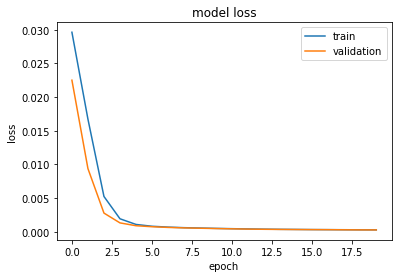

In [11]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [12]:
test_sample_index = 122

# select a sample
original_data = test_set[test_sample_index]
original_data.shape

test_data = (original_data - min_value)/(max_value - min_value) # preprocessing
test_data.shape

decoded_data = autoencoder.predict(np.expand_dims(test_data, 0)) 
decoded_data = decoded_data*(max_value-min_value) + min_value   # scale back

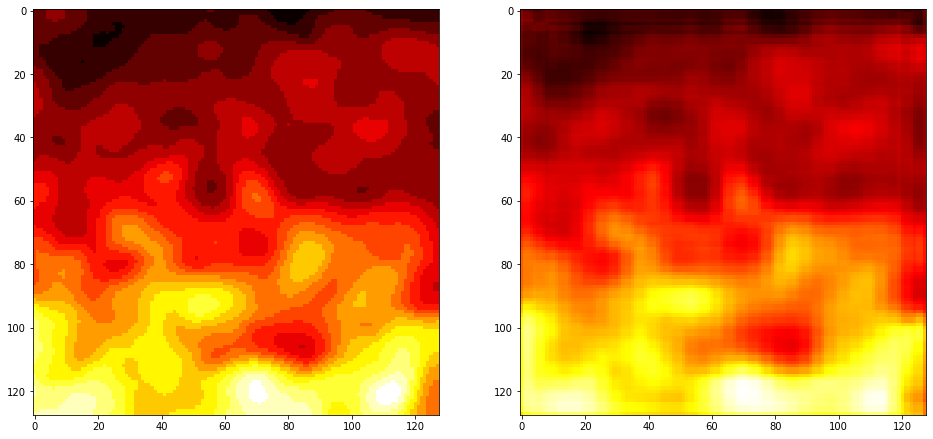

In [13]:
fig = plt.figure(figsize=(16,32)) # image
ax1 = fig.add_subplot(1,2,1) 
ax1.imshow(original_data,cmap='hot')
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(decoded_data.reshape(128,128),cmap='hot')

In [14]:
mse = np.square((original_data-decoded_data)).mean()
mse

0.00023573479198807473

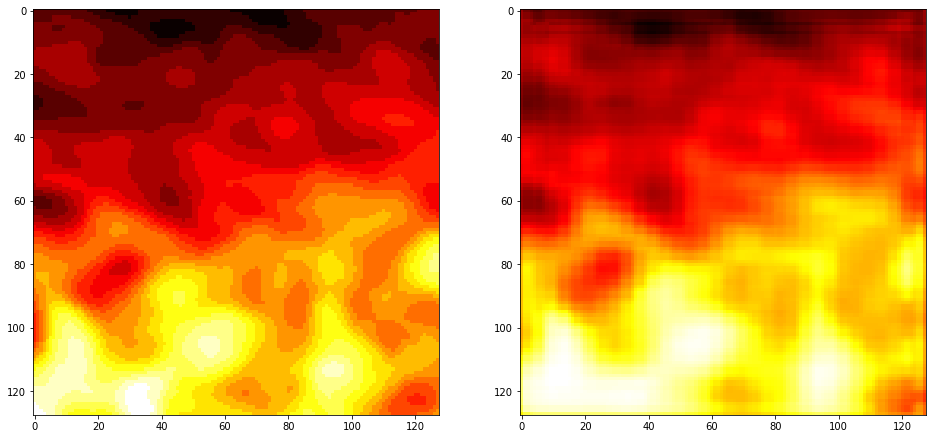

In [15]:
test_sample_index = 110

# select a sample
original_data = test_set[test_sample_index]
original_data.shape

test_data = (original_data - min_value)/(max_value - min_value) # preprocessing
test_data.shape

decoded_data = autoencoder.predict(np.expand_dims(test_data, 0)) 
decoded_data = decoded_data*(max_value-min_value) + min_value   # scale back

fig = plt.figure(figsize=(16,32)) # image
ax1 = fig.add_subplot(1,2,1) 
ax1.imshow(original_data,cmap='hot')
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(decoded_data.reshape(128,128),cmap='hot')

In [16]:
mse = np.square((original_data-decoded_data)).mean()
mse

0.00040277912408285096

In [18]:
autoencoder.save("autoencoder(32,32,4 comparison) layer(4-4) sample(3000 single region)")

INFO:tensorflow:Assets written to: autoencoder(32,32,4 comparison) layer(4-4) sample(3000 single region)\assets
